In [53]:
from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.theta import ThetaForecaster
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
import pandas as pd
from sktime.utils.plotting import plot_series
import sys
from sklearn.metrics import mean_absolute_error, r2_score
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.fbprophet import Prophet
import matplotlib.pyplot as plt
import numpy as np

sys.path.append("..")
import src.utility.plot_settings

Importing plotly failed. Interactive plots will not work.


In [15]:
y = pd.DataFrame(load_airline())

In [38]:

# https://www.sktime.org/en/stable/get_started.html

y = load_airline()
y_train, y_test = temporal_train_test_split(y)
fh = ForecastingHorizon(y_test.index, is_relative=False)
forecaster = ThetaForecaster(sp=12)  # monthly seasonal periodicity
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
mean_absolute_percentage_error(y_test, y_pred)
# plot_series(y, y_pred)

0.0817463656450688

In [99]:
# https://www.kaggle.com/datasets/fedesoriano/traffic-prediction-dataset
traffic = pd.read_csv("../data/raw/traffic.csv", parse_dates=[0], index_col=[0])
traffic = traffic.pivot(columns="Junction", values="Vehicles")

In [152]:
def sktime_forecast(dataset, horizon, forecaster, validation=False, confidence=0.9, frequency="D"):
    """Loop over a time series dataframe, train an sktime forecasting model, and visualize the results.

    Args:
        dataset (pd.DataFrame): Input time series DataFrame with datetime index
        horizon (int): Forecast horizon
        forecaster (sktime.forecasting): Configured forecaster
        validation (bool, optional): . Defaults to False.
        confidence (float, optional): Confidence level. Defaults to 0.9.
        frequency (str, optional): . Defaults to "D".
    """
    
    # Adjust frequency
    forecast_df = dataset.resample(rule=frequency).sum()

    # Interpolate missing periods (if any)
    forecast_df = forecast_df.interpolate(method="time")

    for col in dataset.columns:

        # Use train/test split to validate forecaster
        if validation:
            df = forecast_df[col]

            y_train = df[:-horizon]
            y_test = df.tail(horizon)

            forecaster.fit(y_train)
            fh = ForecastingHorizon(y_test.index, is_relative=False)
            y_pred = forecaster.predict(fh)
            ci = forecaster.predict_interval(fh, coverage=confidence).astype("float")
            y_true = df.tail(horizon)

            mae = mean_absolute_error(y_true, y_pred)

        # Make predictions beyond the dataset
        if not validation:
            df = forecast_df[col].dropna()
            forecaster.fit(df)

            last_date = df.index.max()
            fh = ForecastingHorizon(
                pd.date_range(str(last_date), periods=horizon, freq=frequency),
                is_relative=False,
            )

            y_pred = forecaster.predict(fh)
            ci = forecaster.predict_interval(fh, coverage=confidence).astype("float")
            mae = np.nan

        # Visualize results
        plt.plot(
            df.tail(horizon * 3),
            label="Actual",
            color="black",
        )
        plt.gca().fill_between(
            ci.index, (ci.iloc[:, 0]), (ci.iloc[:, 1]), color="b", alpha=0.1
        )
        plt.plot(y_pred, label="Predicted")
        plt.title(
            f"{horizon} day forecast for {col} (mae: {round(mae, 2)}, confidence: {confidence*100}%)"
        )
        plt.ylim(bottom=0)
        plt.legend()
        plt.show()

15:29:10 - cmdstanpy - INFO - Chain [1] start processing
15:29:10 - cmdstanpy - INFO - Chain [1] done processing


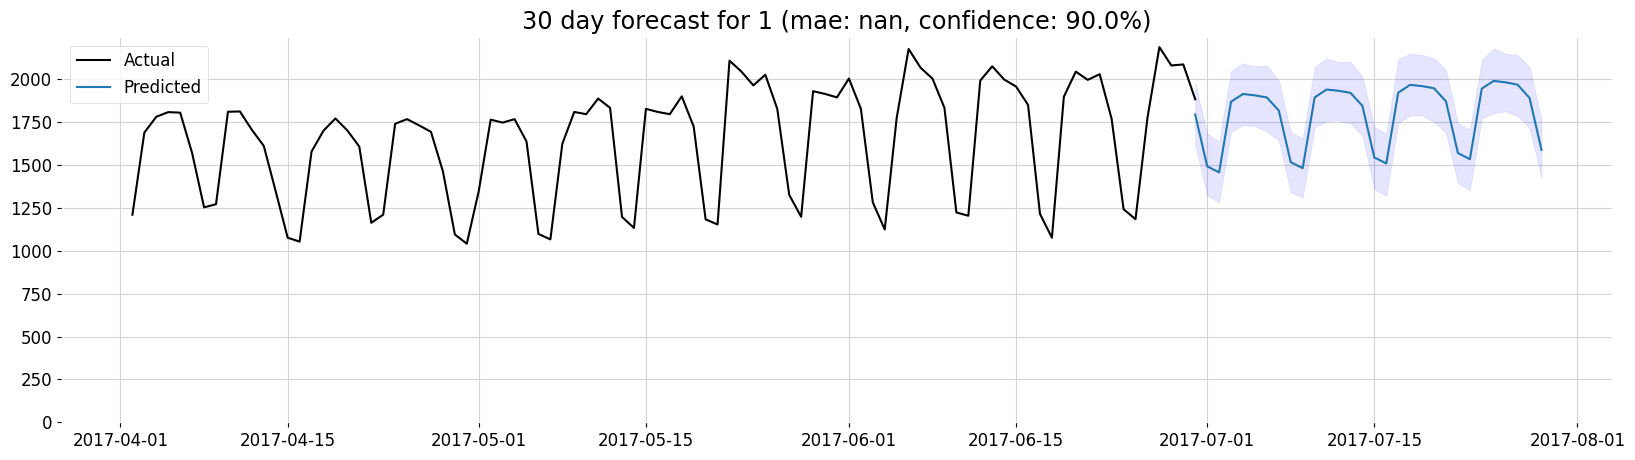

15:29:11 - cmdstanpy - INFO - Chain [1] start processing
15:29:11 - cmdstanpy - INFO - Chain [1] done processing


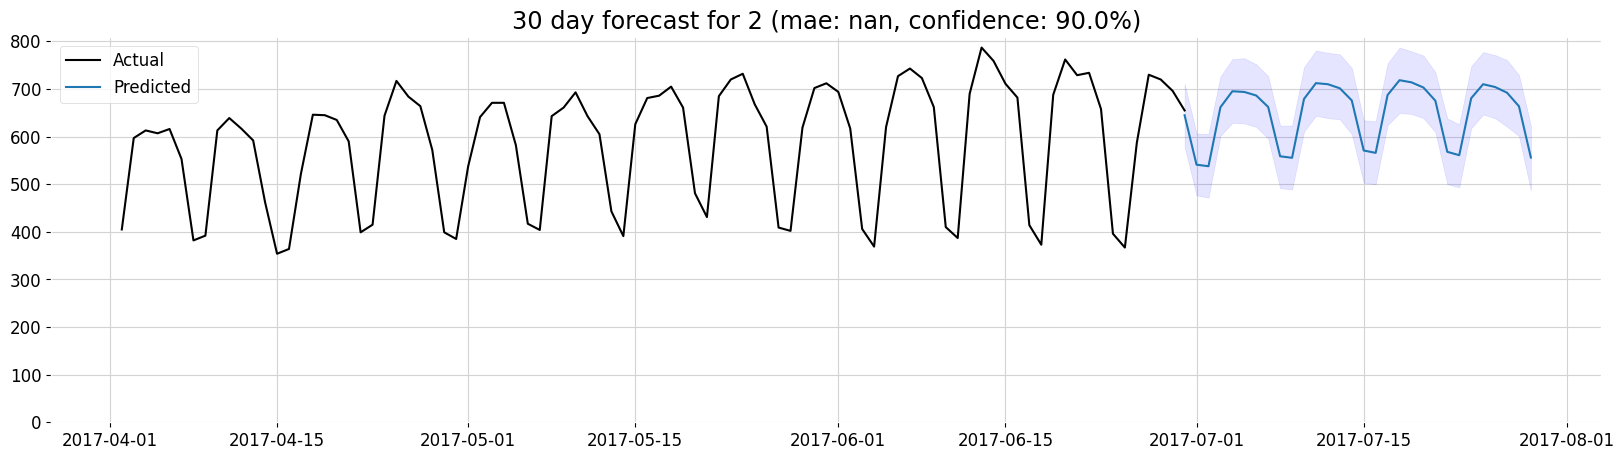

15:29:12 - cmdstanpy - INFO - Chain [1] start processing
15:29:12 - cmdstanpy - INFO - Chain [1] done processing


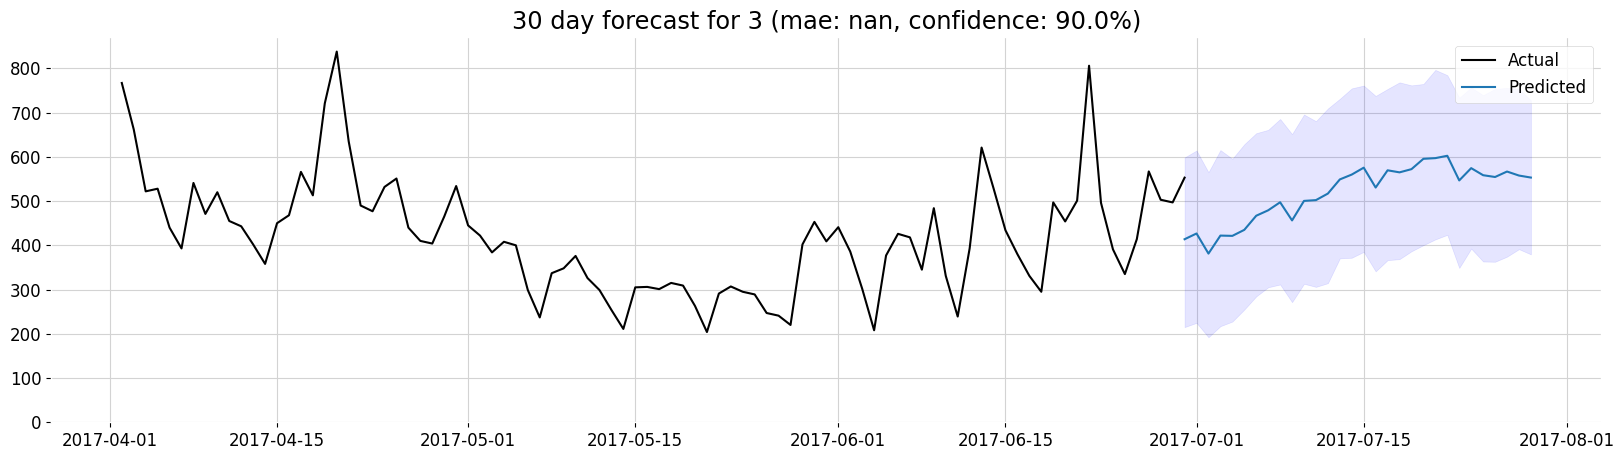

15:29:13 - cmdstanpy - INFO - Chain [1] start processing
15:29:13 - cmdstanpy - INFO - Chain [1] done processing


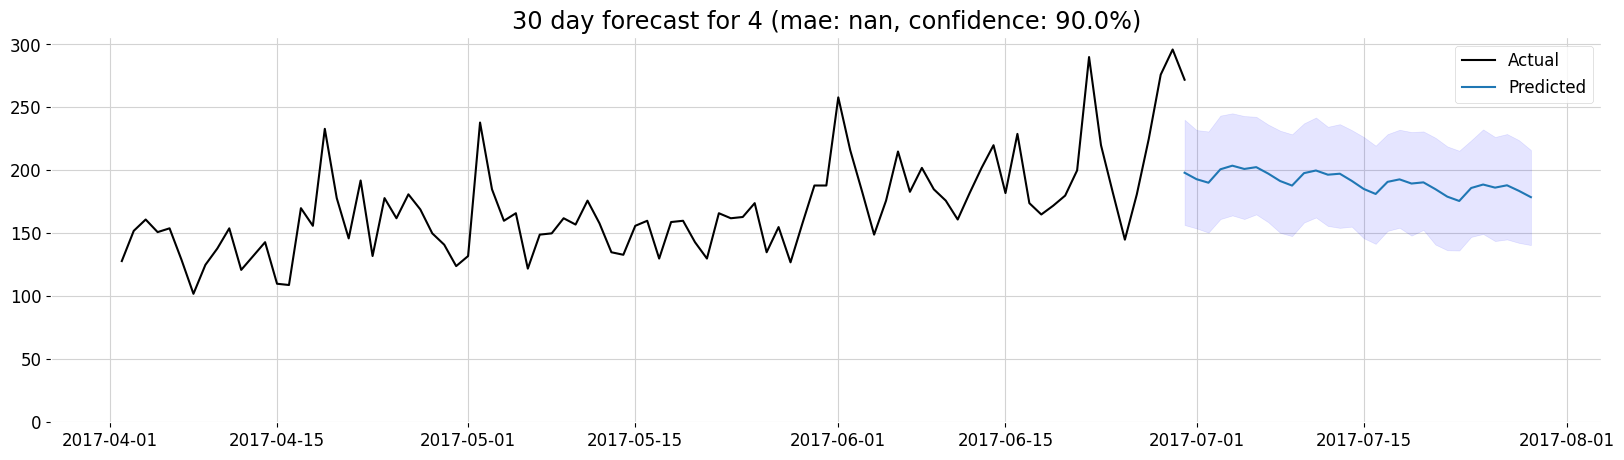

In [155]:
forecaster = Prophet(yearly_seasonality=True, weekly_seasonality=True)
sktime_forecast(dataset=traffic, horizon=30, forecaster=forecaster, validation=False)

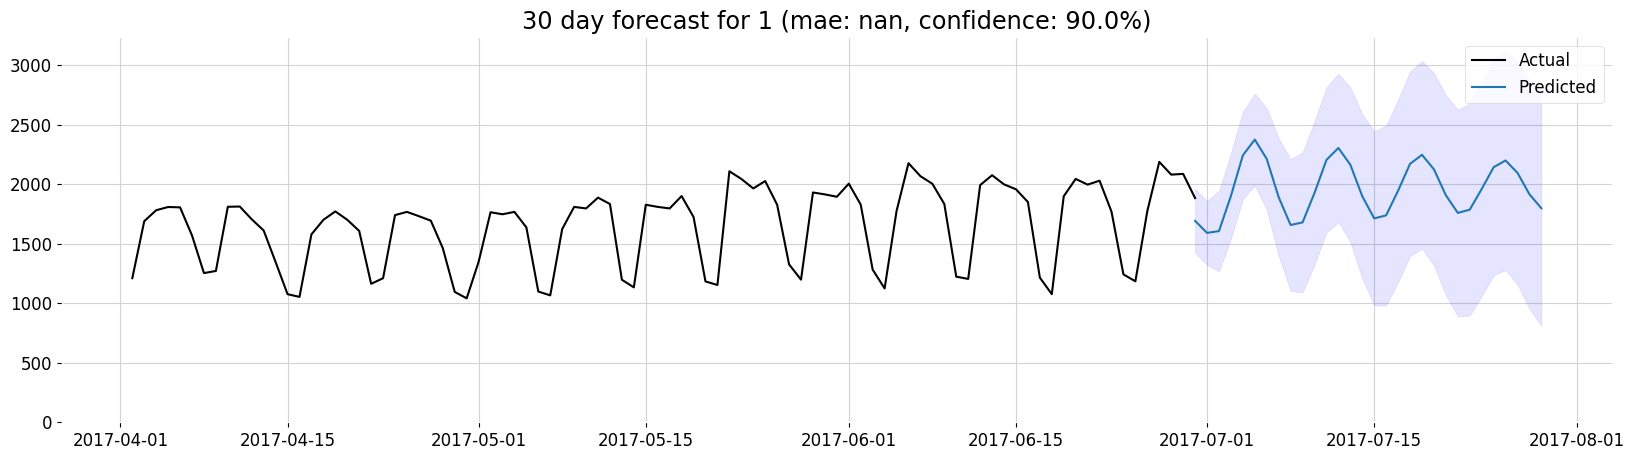

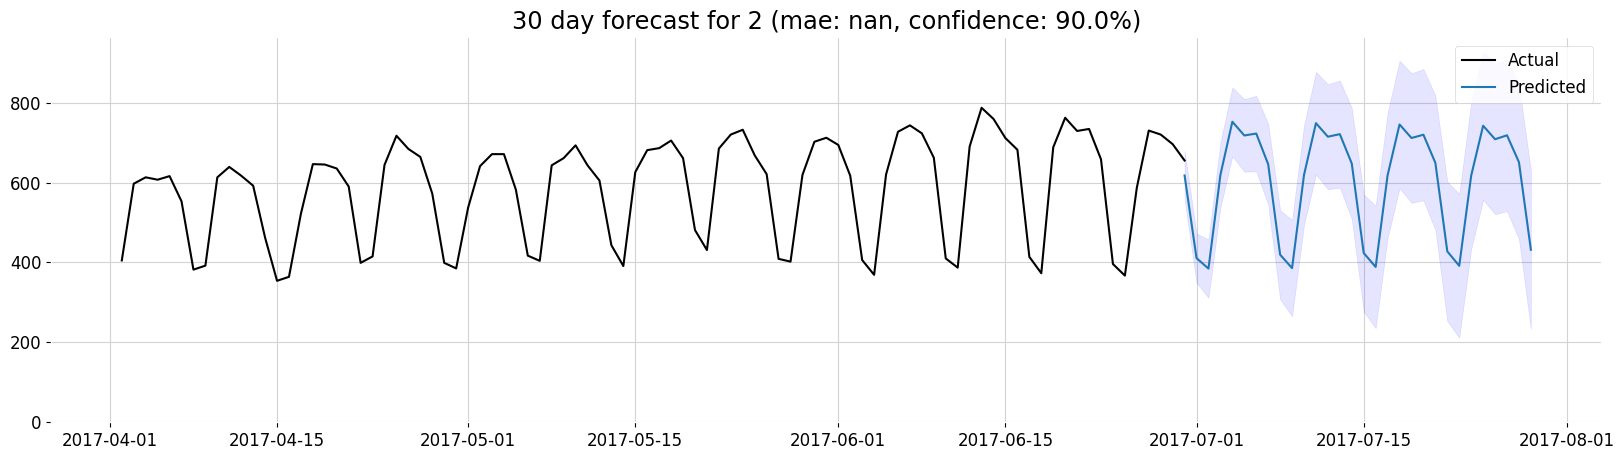

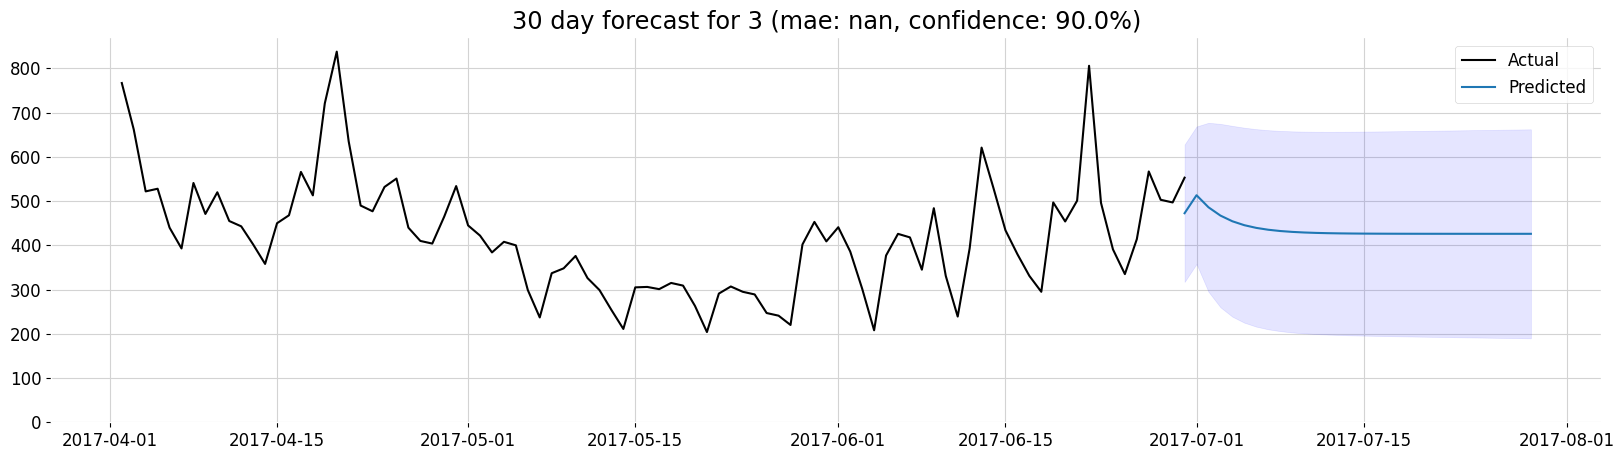

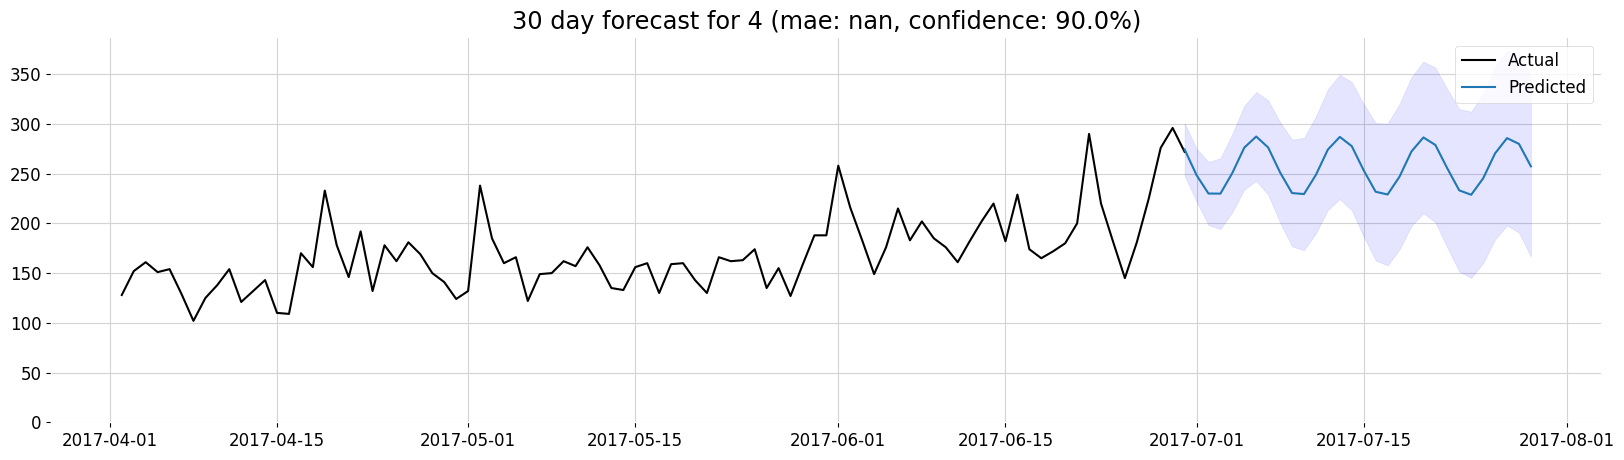

In [156]:
forecaster = AutoARIMA(sp=1, suppress_warnings=True)
sktime_forecast(dataset=traffic, horizon=30, forecaster=forecaster, validation=False)